# Introduction

In this notebook we will be exploring and creating a deep learning model using the tensorflow dataset, fashion_mnist. This dataset consists of a training set of 60,000 samples and test set of 10,000 samples. These samples are in a 28x28 greyscale image associated with 1 of 10 classes. I will be creating a model to predict the class.

In [80]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from collections import Counter
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split

In [81]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [83]:
y_train = to_categorical(np.array(y_train)) 
y_test = to_categorical(np.array(y_test))

In [84]:
len(X_train)

48000

In [85]:
len(X_test)

10000

In [86]:
# Each image's dimension is 28 x 28
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the test images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

# Models

In [87]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

cnn1.summary()

C:\Users\kvedh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history1 = cnn1.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7313 - loss: 0.7976
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8728 - loss: 0.3619
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8882 - loss: 0.3202
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8939 - loss: 0.2905
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9041 - loss: 0.2686
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9133 - loss: 0.2459
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9147 - loss: 0.2394
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9175 - loss: 0.2254
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9224 - loss: 0.2155
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9291 - loss: 0.1973


In [89]:
score = cnn1.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.26114240288734436
Test accuracy: 0.9057000279426575


In [90]:
# get the predictions for the test data
predicted_classes = np.argmax(cnn1.predict(X_test), axis=1)

# get the indices to be plotted
y_true = y_test
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step


C:\Users\kvedh\AppData\Local\Temp\ipykernel_5748\2718503805.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct = np.nonzero(predicted_classes==y_true)[0]
C:\Users\kvedh\AppData\Local\Temp\ipykernel_5748\2718503805.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  incorrect = np.nonzero(predicted_classes!=y_true)[0]


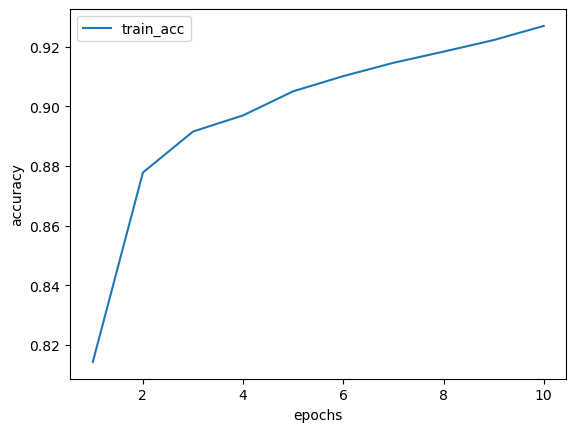

In [100]:
epochs = history1.params['epochs']
x = [i for i in range(1,epochs+1)]
acc = history1.history['accuracy']
plt.plot(x, acc, label="train_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()

# Discussion

I reached an accuracy of 90.5% using 1 convolution layer with a 3x3 feature map size. The next layer is the max pooling layer to reduce the dimensionality of the features. A dropout layer is then added to reduce overfitting. This was set to randomly disable 20% of the neurons. The next step is to add 2 dense layers wuth activation relu and softmax.